In [1]:
import pandas as pd #Importing the libraries
import numpy as np
import glob

In [2]:
#practical approach to  deep learning projects using cnn
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
Test_root = glob.glob('/content/drive/MyDrive/dog cat librosa/test')[0]    #In Python, the glob module is used to retrieve files/pathnames matching a specified pattern.
Train_root = glob.glob('/content/drive/MyDrive/dog cat librosa/train ')[0]
X_path = glob.glob(Test_root + "/dogs/*")
X_path = X_path + glob.glob(Test_root + "/cats/*")
X_path = X_path + glob.glob(Train_root + "/dog/*")
X_path = X_path + glob.glob(Train_root + "/cat/*")

In [4]:
import ntpath        #The ntpath module provides os. path functionality on Windows platforms. You can also use it to handle Windows paths on other platforms. 
                    #This module treats both forward slashes ( / ) and backward slashes ( \ ) as directory separators.
y = np.empty((0, 1, ))
for f in X_path:
    if 'cat' in ntpath.basename(f):
        resp = np.array([0])
        resp = resp.reshape(1, 1, )
        y = np.vstack((y, resp))
    elif 'dog' in ntpath.basename(f):
        resp = np.array([1])
        resp = resp.reshape(1, 1, )
        y = np.vstack((y, resp))
print (f)

/content/drive/MyDrive/dog cat librosa/train /cat/cat_161.wav


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_path, y, test_size=0.25, random_state=42)

In [6]:
import librosa
def librosa_read_wav_files(wav_files):
    if not isinstance(wav_files, list):
        wav_files = [wav_files]
    return [librosa.load(f)[0] for f in wav_files]

In [7]:
wav_rate = librosa.load(X_train[0])[1]
X_train = librosa_read_wav_files(X_train)
X_test  = librosa_read_wav_files(X_test)

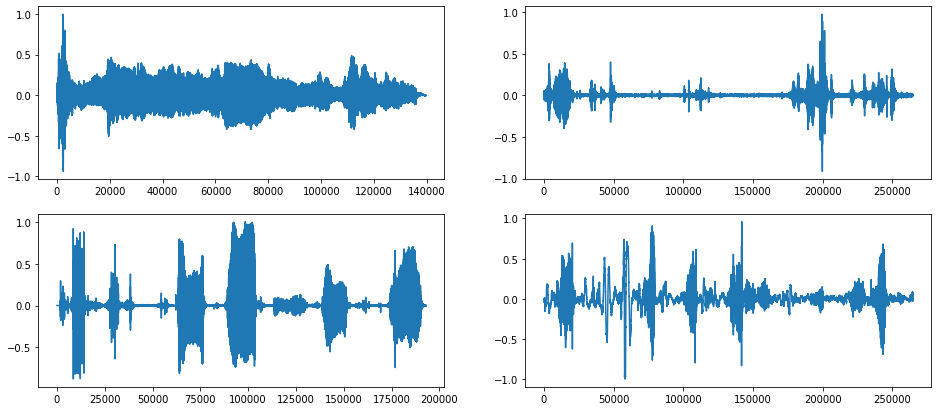

In [8]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(16,7))
axs[0][0].plot(X_train[0])
axs[0][1].plot(X_train[1])
axs[1][0].plot(X_train[2])
axs[1][1].plot(X_train[3])
plt.show()

In [10]:
def extract_features(audio_samples, sample_rate):
    extracted_features = np.empty((0, 41, ))
    if not isinstance(audio_samples, list):
        audio_samples = [audio_samples]
        
    for sample in audio_samples:
        zero_cross_feat = librosa.feature.zero_crossing_rate(sample).mean()
        mfccs = librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        mfccsscaled = np.append(mfccsscaled, zero_cross_feat)
        mfccsscaled = mfccsscaled.reshape(1, 41, )
        extracted_features = np.vstack((extracted_features, mfccsscaled))
    return extracted_features

In [11]:
X_train_features = extract_features(X_train, wav_rate)
X_test_features  = extract_features(X_test, wav_rate)

In [12]:
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import to_categorical

In [13]:
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

In [14]:
model = models.Sequential()
model.add(layers.Dense(100, activation = 'relu', input_shape = (41, )))
model.add(layers.Dense(50, activation = 'relu'))
model.add(layers.Dense(2, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4200      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
Total params: 9,352
Trainable params: 9,352
Non-trainable params: 0
_________________________________________________________________


In [15]:
best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
callbacks = [checkpoint]
model.compile(optimizer='SGD',
              loss=losses.categorical_crossentropy,
              metrics=['accuracy'])

In [16]:
history = model.fit(
    X_train_features,
    train_labels,
    validation_data=(X_test_features,test_labels),
    epochs = 200, 
    verbose = 1,
    callbacks=callbacks,
)

Epoch 1/200
6/6 [==============================] - 1s 121ms/step - loss: 166.4683 - accuracy: 0.4869 - val_loss: 1.8029 - val_accuracy: 0.5397
Epoch 2/200
6/6 [==============================] - 0s 10ms/step - loss: 1.2585 - accuracy: 0.5701 - val_loss: 24.8257 - val_accuracy: 0.7143
Epoch 3/200
6/6 [==============================] - 0s 11ms/step - loss: 9.0942 - accuracy: 0.5715 - val_loss: 0.6446 - val_accuracy: 0.4603
Epoch 4/200
6/6 [==============================] - 0s 11ms/step - loss: 0.6870 - accuracy: 0.4987 - val_loss: 0.6840 - val_accuracy: 0.7143
Epoch 5/200
6/6 [==============================] - 0s 12ms/step - loss: 0.7601 - accuracy: 0.6171 - val_loss: 0.5914 - val_accuracy: 0.7143
Epoch 6/200
6/6 [==============================] - 0s 12ms/step - loss: 0.6892 - accuracy: 0.6572 - val_loss: 0.6038 - val_accuracy: 0.7143
Epoch 7/200
6/6 [==============================] - 0s 11ms/step - loss: 0.6631 - accuracy: 0.6197 - val_loss: 0.6091 - val_accuracy: 0.7143
Epoch 8/200
6/6 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


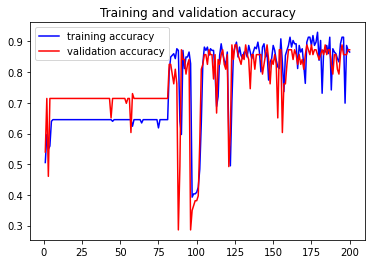

In [17]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'b', label = "training accuracy")
plt.plot(epochs, val_acc, 'r', label = "validation accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [19]:
model.save_weights('model_wieghts.h7')
model.save('model_keras.h7')

INFO:tensorflow:Assets written to: model_keras.h7/assets


Cat: 0.8903340101242065 Dog: 0.10966596007347107
This is a cat meowing


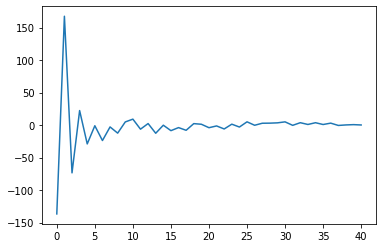

In [20]:
nr_to_predict = 5
pred = model.predict(X_test_features[nr_to_predict].reshape(1, 41,))
print("Cat: {} Dog: {}".format(pred[0][0], pred[0][1]))
if (y_test[nr_to_predict] == 0):
    print ("This is a cat meowing")
else:
    print ("This is a dog barking")
    
plt.plot(X_test_features[nr_to_predict])
#ipd.Audio(X_test[nr_to_predict],  rate=wav_rate)

Cat: 0.3294335901737213 Dog: 0.6705663204193115
This is a dog barking


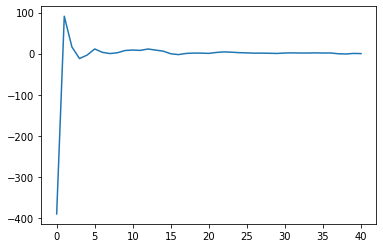

In [21]:
nr_to_predict = 2
pred = model.predict(X_test_features[nr_to_predict].reshape(1, 41,))
print("Cat: {} Dog: {}".format(pred[0][0], pred[0][1]))
if (y_test[nr_to_predict] == 0):
    print ("This is a cat meowing")
else:
    print ("This is a dog barking")
    
plt.plot(X_test_features[nr_to_predict])
#ipd.Audio(X_test[nr_to_predict],  rate=wav_rate)